In [3]:
# 모듈 import
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\up\\b7a6f709_nohash_0.wav', shape=(), dtype=string)


In [7]:
# 데이터 분할
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [9]:
# 오디오 파일 및 레이블 read
test_file = tf.io.read_file(DATASET_PATH+'/down/00b01445_nohash_1.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([16000, 1])

In [10]:
# wav - > audio tensor로 변환하는 함수
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)

In [14]:
# 레이블을 생성하는 함수
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep
    )
    return parts[-2]

In [15]:
#오디오 데이터와 라벨을 하나로 묶는 함수
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [16]:
# 오디오 레이블 쌍을 추출하도록 훈련  세트를 빌드
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE
)

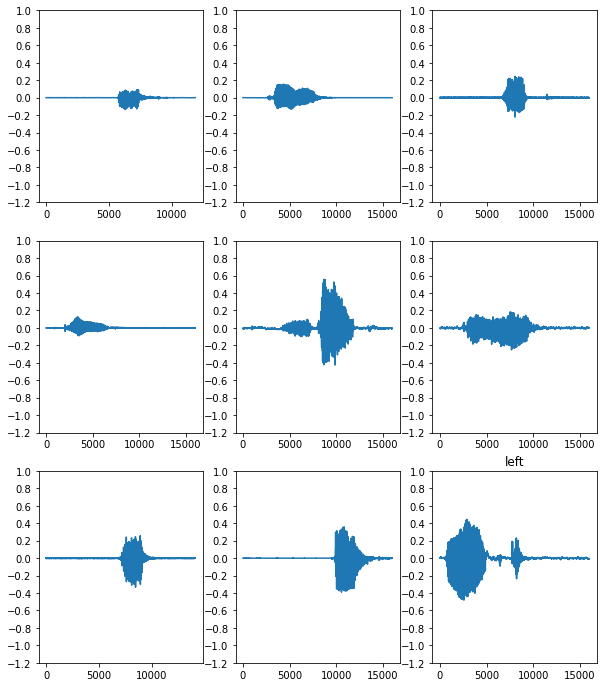

In [17]:
# 오디오를 플로팅
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
ax.set_title(label)

plt.show()

In [18]:
# 파형을 스펙트럼으로 변환
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [19]:
# 스펙트럼 모양 보고 원본 오디오 재생
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: up
Waveform shape: (11889,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [23]:
# 스펙트럼을 표시
def plot_spectrogram(spectrogram,ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
        log_spec = np.log(spectrogram.T + np.finfo(float).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        X = np.linspace(0, np.size(spectrogram), num=width, dtype=int )
        Y = range(height)
        ax.pcolormesh(X,Y,log_spec)

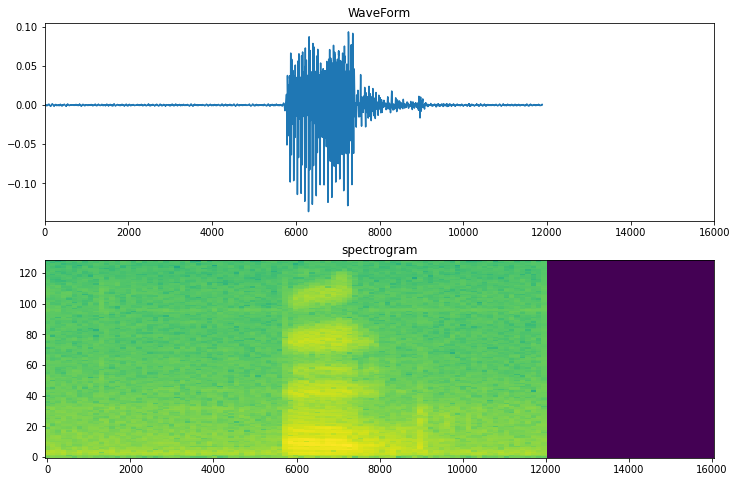

In [24]:
#시간에 따른 파형과 스펙트럼을 시각화
fig, axes = plt.subplots(2,figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale,waveform.numpy())
axes[0].set_title('WaveForm')
axes[0].set_xlim([0,16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('spectrogram')
plt.show()

In [28]:
# 파형데이터를 스펙트럼으로 변환하고 해당 레이블을 정수id로 변환
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [29]:
# 데이터 셋 전체 데이터를 map
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

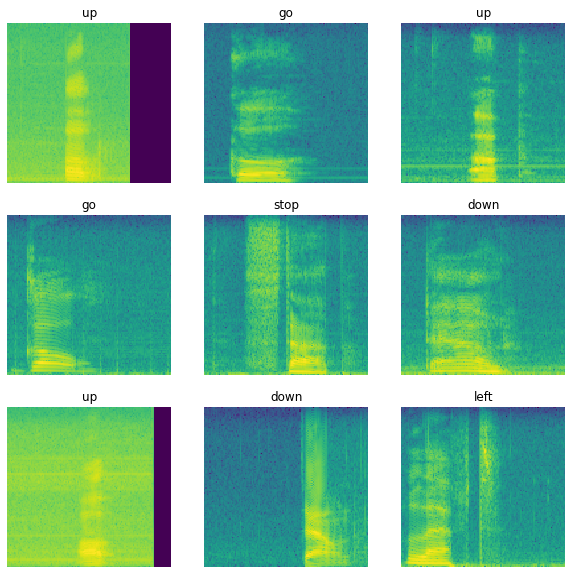

In [30]:
# 오디오 데이터에 대한 스펙트럼을 조사
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

In [31]:
# 검증 및 테스트 데이터에 대한 훈련세트 전처리
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
    return output_ds

In [32]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [33]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [34]:
# 시간 save를 위해서 훈련하는 동안 read 시간을 줄임
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [37]:
# 오디오 ->이미지
# CNN 
for spectrogram, _ in  spectrogram_ds.take(1):
    input_shape = spectrogram.shape
input_shape    

TensorShape([124, 129, 1])

In [38]:
num_labels = len(commands)
num_labels

8

In [49]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)       

In [50]:
model.compile(
    optimizer="Adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [51]:

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,patience=2)
)

Epoch 1/20
100/100 [==============================] - 13s 130ms/step - loss: 1.7825 - accuracy: 0.3578 - val_loss: 1.3578 - val_accuracy: 0.5775
Epoch 2/20
100/100 [==============================] - 12s 118ms/step - loss: 1.2218 - accuracy: 0.5763 - val_loss: 0.9496 - val_accuracy: 0.6963
Epoch 3/20
100/100 [==============================] - 11s 112ms/step - loss: 0.9465 - accuracy: 0.6689 - val_loss: 0.7803 - val_accuracy: 0.7287
Epoch 4/20
100/100 [==============================] - 11s 109ms/step - loss: 0.7556 - accuracy: 0.7295 - val_loss: 0.7102 - val_accuracy: 0.7663
Epoch 5/20
100/100 [==============================] - 10s 105ms/step - loss: 0.6712 - accuracy: 0.7605 - val_loss: 0.6630 - val_accuracy: 0.7788
Epoch 6/20
100/100 [==============================] - 10s 104ms/step - loss: 0.5704 - accuracy: 0.7939 - val_loss: 0.5765 - val_accuracy: 0.8125
Epoch 7/20
100/100 [==============================] - 10s 104ms/step - loss: 0.5018 - accuracy: 0.8219 - val_loss: 0.5506 - val_ac

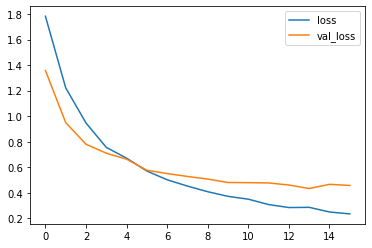

In [52]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'],metrics['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()

In [53]:
# 모델 성능 평가
test_audio = []
test_labels = []
for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())
test_audio = np.array(test_audio)    
test_labels = np.array(test_labels)

In [57]:
# 예측
y_pred =  np.argmax(model.predict(test_audio),axis=1)
y_true = test_labels
test_acc = sum(y_pred == y_true)/len(y_true)
test_acc

25/25 [==============================] - 0s 13ms/step


0.8725

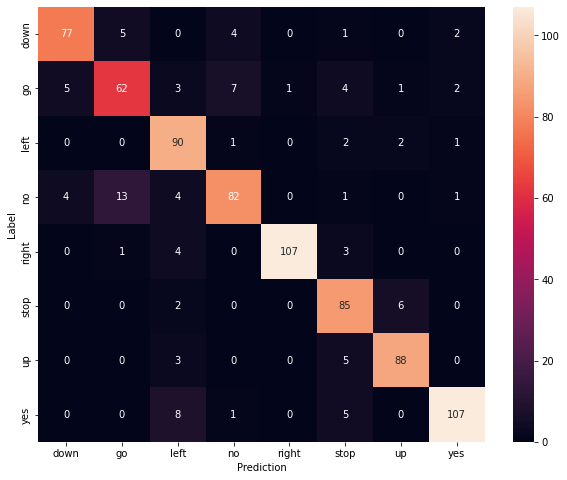

In [58]:
#혼동행렬을 이용해서 모델이 각 세트의 명령을 얼마나 잘 분류했는지 확인
confusion_mtx =  tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True,fmt='g'
           )
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [80]:
# stop 이라는 첫번째 사운드에 대해서 모델의 예측
# 0b40aa8e_nohash_0.wav
sample_file = data_dir/'go/0a9f9af7_nohash_0.wav'

In [81]:
sample_ds = preprocess_dataset([str(sample_file)])

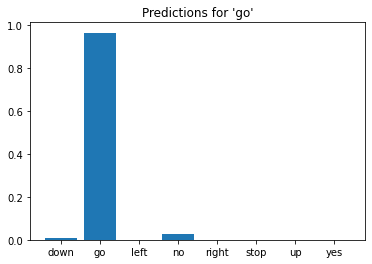

In [85]:
for spectrogram, label in  sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f"Predictions for '{commands[label[0]]}'")
    plt.show()          
              

In [79]:
sample_ds

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, 129, 1), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>